In [1]:
# Imports & stuff

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from cycler import cycler
from scipy.signal import savgol_filter

# Constants
time = 3600
discount = 0.95
pres_sarsop = []
pres_ub = []
# all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag", "Hallway1", "Hallway2", "MiniHallway", "TigerGrid"] # All envs
all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
            "FrozenLake4", "FrozenLake10", "Tag",  "SparseHallway1", "SparseHallway2", "SparseTigerGrid"] # Messing around...
# all_envs = ["ABC", "Tiger", "RockSample5", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag",  "SparseHallway1", "SparseHallway2", "SparseTigerGrid"] # Messing around...
Env_to_latex_name = {
    "ABC" : "\\custom",
    "Tiger":"\\tiger",
    "RockSample5": "\\rocksample (5)",
    "RockSample10": "\\rocksample (10)",
    "K-out-of-N2":"\\koutofn (2)",
    "K-out-of-N3":"\\koutofn (3)",
    "FrozenLake4":"\\lake (4)",
    "FrozenLake10":"\\lake (10)",
    "Tag":"\\tagenv",
    "Hallway1":"\\hallway1",
    "Hallway2":"\\hallway2",
    "TigerGrid":"\\tigergrid",
    "SparseHallway1":"\\hallwayone",
    "SparseHallway2":"\\hallwaytwo",
    "SparseTigerGrid":"\\tigergrid",
    "MiniHallway":"\\minihallway"
}

solver_to_heuristic = {
    "SARSOP" : "FIB",
    "BIB-SARSOP" : "BIB",
    "EBIB-SARSOP" : "EBIB"
}



# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4"] #Testing envs
# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4", "FrozenLake10", "K-out-of-N3"] #Testing envs
pre_sarsop = "./Data/SarsopTest/Sarsoptest_"
pre_ub = "./Data/UpperBounds/UpperBoundTest_"
post_sarsop = f"_t{time}_d{str(discount)[2:]}.json"
post_ub =f"_d{str(discount)[2:]}.json"
for env in all_envs:
    pres_ub.append(pre_ub + env + "_")

# solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
# solvers = ["SARSOP", "BIB-SARSOP"]

def get_data_plot(env:str):
    ts, ubs, lbs = [], [], []
    solvernames, envname = [], ""
    for s in solvers:
        filename = pre_sarsop+env+"_"+s+post_sarsop
        with open(filename) as file:
            data = json.load(file)
            ts.append(data["times"])
            ubs.append(data["ubs"])
            lbs.append(data["lbs"])
            solvernames.append(data["solver"])
            envname = data["env_full"]

    return ts, ubs, lbs, solvernames, envname


def get_data_discounts(env, discounts):
    times, init_times = [], []
    solvernames = []
    for (s_idx, s) in enumerate(solvers):
        solvernames.append(s)
        times.append([])
        init_times.append([])
        for d in discounts:
            filename = f'./Data/DiscountTest/Sarsoptest_{env}_{s}_t{time}_d{str(round(d, 4))[2:]}.json'
            with open(filename) as file:
                data = json.load(file)
                times[s_idx].append(data["runtime"])
                init_times[s_idx].append(data["times"][0])

    return times, init_times, solvernames



### Plotting

### Tables

In [2]:
# # SARSOP Convergence test - Large

# def get_vars_sarsop(data:dict):
#     if data["timeout"]:
#         # diff =  abs((data["final_ub"] - data["final_lw"] ) / data["final_lw"])
#         diff = abs(data["final_ub"] - data["final_lw"])
#         # return f' TO ({diff:.2f})'
#         return f'{data["final_lw"]:.2f}, {data["final_ub"]:.2f}'
#     else:
#         return f'{data["runtime"]:.2f}s'


# # labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
# labels = ["\\FIB", "", "\\BIB","", "\\EBIB",""]
# names = []
# Sarsop_lb, BibSarsop_lb, EBibSarsop_lb = [], [], []
# Sarsop_ub, BibSarsop_ub, EBibSarsop_ub = [], [], []
# Sarsop_its, BibSarsop_its, EBibSarsop_its = [], [], []
# Sarsop_ravg, BibSarsop_ravg, EBibSarsop_ravg = [], [], []

# for env in all_envs:
#     pres_sarsop.append(pre_sarsop + env + "_" )
# envs_sarsop = ["K-out-of-N3", "FrozenLake10","Tag","SparseHallway1", "SparseHallway2","SparseTigerGrid"]

# for env in envs_sarsop:
#     thispre = pre_sarsop + env + "_"
#     filename_Sarsop = thispre + "SARSOP" + post_sarsop
#     # print(pre)
#     with open(filename_Sarsop) as file:
#         this_data = json.load(file)
#         # names.append(this_data["env_full"])
#         names.append(Env_to_latex_name[this_data["env"]])
#         Sarsop_lb.append(f'{this_data["final_lw"]:.2f}')
#         Sarsop_ub.append(f'{this_data["final_ub"]:.2f}')
#         Sarsop_its.append(len(this_data["times"]))
#         Sarsop_ravg.append(f'{this_data["sim_r"]:.2f}')
#         # print("Sarsop: ", len(this_data["times"]))

#     filename_BibSarsop = thispre + "BIB-SARSOP" + post_sarsop
#     with open(filename_BibSarsop) as file:
#         this_data = json.load(file)
#         BibSarsop_lb.append(f'{this_data["final_lw"]:.2f}')
#         BibSarsop_ub.append(f'{this_data["final_ub"]:.2f}')
#         BibSarsop_its.append(len(this_data["times"]))
#         BibSarsop_ravg.append(f'{this_data["sim_r"]:.2f}')
#         # print("BIBSarsop: ", len(this_data["times"]))

#     filename_EBibSarsop = thispre + "EBIB-SARSOP" + post_sarsop
#     with open(filename_EBibSarsop) as file:
#         this_data = json.load(file)
#         EBibSarsop_lb.append(f'{this_data["final_lw"]:.2f}')
#         EBibSarsop_ub.append(f'{this_data["final_ub"]:.2f}')
#         EBibSarsop_its.append(len(this_data["times"]))
#         EBibSarsop_ravg.append(f'{this_data["sim_r"]:.2f}')
#         # print("BIBSarsop: ", len(this_data["times"]))

# dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, BibSarsop_lb, BibSarsop_ub,EBibSarsop_lb, EBibSarsop_ub,], index=labels, columns=names).transpose()

# # dataframe = pd.DataFrame([Sarsop_ravg, BibSarsop_ravg, EBibSarsop_ravg], index=labels, columns=names).transpose()


# print(dataframe)

# print(dataframe.to_latex(column_format="l||cc|cc|cc"))

In [3]:
# SARSOP Convergence test - Large

def get_time_sarsop(data:dict, tmax):
    times, ubs, lbs = data["times"], data["ubs"], data["lbs"]
    for (i, t) in enumerate(times):
        if t > tmax:
            if i == 0:
                return "N/A"
            # diff = abs(( ubs[i] - lbs[i]) / ubs[i])
            diff = abs(( ubs[i-1] - lbs[i-1]) / lbs[i-1])
            return f'{diff:.2f}'
    # diff = abs(( data["final_ub"] - data["final_lw"]) / data["final_ub"])
    # diff = abs(( data["final_ub"] - data["final_lw"]) / data["final_lb"])
    diff = 0
    return f'{diff:.2f}'


# labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
# labels = ["\\FIB", "", "\\BIB","", "\\EBIB",""]
# labels = ["900s", "1800s", "3600s", "900s", "1800s", "3600s","900s", "1800s", "3600s"]
labels = ["\\FIB", "\\BIB", "\\EBIB","\\FIB", "\\BIB", "\\EBIB","\\FIB", "\\BIB", "\\EBIB"]
# labels = ["15 min", "30 min", "60 min","15 min", "30 min", "60 min","15 min", "30 min", "60 min",]
names = []
Data = []
for _l in labels:
    Data.append([])


times = [600, 1200, 3600]

for env in all_envs:
    pres_sarsop.append(pre_sarsop + env + "_" )
envs_sarsop = ["K-out-of-N3", "FrozenLake10","Tag","SparseHallway1", "SparseHallway2","SparseTigerGrid"]

for env in envs_sarsop:
    thispre = pre_sarsop + env + "_"
    filename_Sarsop = thispre + "SARSOP" + post_sarsop
    # print(pre)
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        names.append(Env_to_latex_name[this_data["env"]])
        Data[0].append(get_time_sarsop(this_data, times[0]))
        Data[3].append(get_time_sarsop(this_data, times[1]))
        Data[6].append(get_time_sarsop(this_data, times[2]))

    filename_BibSarsop = thispre + "BIB-SARSOP" + post_sarsop
    with open(filename_BibSarsop) as file:
        this_data = json.load(file)
        Data[1].append(get_time_sarsop(this_data, times[0]))
        Data[4].append(get_time_sarsop(this_data, times[1]))
        Data[7].append(get_time_sarsop(this_data, times[2]))

    filename_EBibSarsop = thispre + "EBIB-SARSOP" + post_sarsop
    with open(filename_EBibSarsop) as file:
        this_data = json.load(file)
        Data[2].append(get_time_sarsop(this_data, times[0]))
        Data[5].append(get_time_sarsop(this_data, times[1]))
        Data[8].append(get_time_sarsop(this_data, times[2]))

# dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, BibSarsop_lb, BibSarsop_ub,EBibSarsop_lb, EBibSarsop_ub,], index=labels, columns=names).transpose()

dataframe = pd.DataFrame(Data, index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="l||rrr|rrr|rrr"))

              \FIB  \BIB \EBIB  \FIB  \BIB \EBIB  \FIB  \BIB \EBIB
\koutofn (3)  0.20  0.11  0.11  0.19  0.10  0.10  0.17  0.09  0.09
\lake (10)    1.09  0.59  0.55  0.94  0.55  0.51  0.87  0.47  0.44
\tagenv       0.41  0.38  0.38  0.40  0.36  0.37  0.38  0.34  0.34
\hallwayone   0.17  0.12  0.13  0.17  0.12  0.11  0.17  0.11  0.11
\hallwaytwo   1.24  1.05   N/A  1.22  1.02  1.08  1.10  0.94  0.97
\tigergrid    0.11  0.08  0.09  0.11  0.08  0.08  0.11  0.08  0.08
\begin{tabular}{l||rrr|rrr|rrr}
\toprule
 & \FIB & \BIB & \EBIB & \FIB & \BIB & \EBIB & \FIB & \BIB & \EBIB \\
\midrule
\koutofn (3) & 0.20 & 0.11 & 0.11 & 0.19 & 0.10 & 0.10 & 0.17 & 0.09 & 0.09 \\
\lake (10) & 1.09 & 0.59 & 0.55 & 0.94 & 0.55 & 0.51 & 0.87 & 0.47 & 0.44 \\
\tagenv & 0.41 & 0.38 & 0.38 & 0.40 & 0.36 & 0.37 & 0.38 & 0.34 & 0.34 \\
\hallwayone & 0.17 & 0.12 & 0.13 & 0.17 & 0.12 & 0.11 & 0.17 & 0.11 & 0.11 \\
\hallwaytwo & 1.24 & 1.05 & N/A & 1.22 & 1.02 & 1.08 & 1.10 & 0.94 & 0.97 \\
\tigergrid & 0.11 & 0.08 &

In [4]:
# SARSOP Convergence test - Small

def get_time_per_iter(data:dict):
    if len(data["times"]) == 1:
        return "N/A"
    avg_time = (data["runtime"] - data["times"][0]) / (len(data["times"])-1)
    return f'{avg_time:.2e}s'

def get_perc_heuristic_time(data:dict):
    return (data["times"][0] / data["runtime"])

# labels = ["\\FIB", "", "\\BIB","", "\\EBIB","", "\\OBIB",""]
labels = ["\\FIB", "\\BIB","\\EBIB"]
# labels = ["T", "N_E","T", "N_E","T", "N_E", ]
names = []

Data = []
for _l in labels:
    Data.append([])

envs_sarsop = ["ABC","Tiger", "RockSample5", "FrozenLake4",  "K-out-of-N2"]
# envs_sarsop = ["ABC","Tiger", "RockSample5", "FrozenLake4"]

for env in all_envs:
    pres_sarsop.append(pre_sarsop + env + "_" )



for env in envs_sarsop:
    thispre = pre_sarsop + env + "_"
    filename_Sarsop = thispre + "SARSOP" + post_sarsop
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        names.append(Env_to_latex_name[this_data["env"]])
        Data[0].append(f'{this_data["runtime"]:.3f}s')
        # Data[1].append(len(this_data["times"])-1)
        # Data[1].append(get_perc_heuristic_time(this_data))


    filename_BibSarsop = thispre + "BIB-SARSOP" + post_sarsop
    with open(filename_BibSarsop) as file:
        this_data = json.load(file)
        Data[1].append(f'{this_data["runtime"]:.3f}s')
        # Data[3].append(len(this_data["times"])-1)
        # Data[3].append(get_perc_heuristic_time(this_data))

    filename_EBibSarsop = thispre + "EBIB-SARSOP" + post_sarsop
    with open(filename_EBibSarsop) as file:
        this_data = json.load(file)
        Data[2].append(f'{this_data["runtime"]:.3f}s')
        # Data[5].append(len(this_data["times"])-1)
        # Data[5].append(get_perc_heuristic_time(this_data))

    # filename_EBibSarsop = thispre + "WBIB-SARSOP" + post_sarsop
    # with open(filename_EBibSarsop) as file:
    #     this_data = json.load(file)
    #     Data[6].append(f'{this_data["runtime"]:.2f}s')
    #     Data[7].append(len(this_data["times"])-1)



print(Data)
# dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, BibSarsop_lb, BibSarsop_ub,EBibSarsop_lb, EBibSarsop_ub,], index=labels, columns=names).transpose()

dataframe = pd.DataFrame( Data, index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="l||rrr"))

[['0.058s', '0.087s', '1.000s', '0.185s', '164.907s'], ['0.020s', '0.027s', '1.051s', '0.192s', '46.092s'], ['0.025s', '0.018s', '0.974s', '0.258s', '46.880s']]
                     \FIB     \BIB    \EBIB
\custom            0.058s   0.020s   0.025s
\tiger             0.087s   0.027s   0.018s
\rocksample (5)    1.000s   1.051s   0.974s
\lake (4)          0.185s   0.192s   0.258s
\koutofn (2)     164.907s  46.092s  46.880s
\begin{tabular}{l||rrr}
\toprule
 & \FIB & \BIB & \EBIB \\
\midrule
\custom & 0.058s & 0.020s & 0.025s \\
\tiger & 0.087s & 0.027s & 0.018s \\
\rocksample (5) & 1.000s & 1.051s & 0.974s \\
\lake (4) & 0.185s & 0.192s & 0.258s \\
\koutofn (2) & 164.907s & 46.092s & 46.880s \\
\bottomrule
\end{tabular}



In [5]:
# SARSOP Convergence test - Combined

# def get_vars_sarsop(data:dict):
#     if data["timeout"]:
#         # diff =  abs((data["final_ub"] - data["final_lw"] ) / data["final_lw"])
#         diff = abs(data["final_ub"] - data["final_lw"])
#         return f' {diff:.2f}'
#         # return f'{data["final_lw"]:.2f}, {data["final_ub"]:.2f}'
#     else:
#         return f'{data["runtime"]:.2f}s'


# # labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
# labels = ["\\FIB",  "\\BIB", "\\EBIB"]
# names = []

# Data = [[],[],[]]

# Sarsop_lb, BibSarsop_lb, EBibSarsop_lb = [], [], []
# Sarsop_ub, BibSarsop_ub, EBibSarsop_ub = [], [], []
# Sarsop_its, BibSarsop_its, EBibSarsop_its = [], [], []
# Sarsop_times, BibSarsop_times, EBibSarsop_times = [], [], []
# Sarsop_data, BibSarsop_data, EBibSarsop_data = [], [], []

# for env in all_envs:
#     pres_sarsop.append(pre_sarsop + env + "_" )
# envs_sarsop = ["ABC","Tiger", "RockSample5", "FrozenLake4",  "K-out-of-N2",
#                "RockSample10","FrozenLake10", "K-out-of-N3","Tag", "SparseHallway1", "SparseHallway2","SparseTigerGrid"]

# for env in envs_sarsop:
#     thispre = pre_sarsop + env + "_"
#     filename_Sarsop = thispre + "SARSOP" + post_sarsop
#     with open(filename_Sarsop) as file:
#         names.append(Env_to_latex_name[this_data["env"]])
#         this_data = json.load(file)
#         d0 = get_vars_sarsop(this_data)
#         Data[0].append(d0)

#     filename_BibSarsop = thispre + "BIB-SARSOP" + post_sarsop
#     with open(filename_BibSarsop) as file:
#         this_data = json.load(file)
#         d1 = get_vars_sarsop(this_data)
#         Data[1].append(d1)

#     filename_EBibSarsop = thispre + "EBIB-SARSOP" + post_sarsop
#     with open(filename_EBibSarsop) as file:
#         this_data = json.load(file)
#         d2 = get_vars_sarsop(this_data)
#         Data[2].append(d2)



# print(Data)
# # dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, BibSarsop_lb, BibSarsop_ub,EBibSarsop_lb, EBibSarsop_ub,], index=labels, columns=names).transpose()

# dataframe = pd.DataFrame( Data, index=labels, columns=names).transpose()


# print(dataframe)

# print(dataframe.to_latex(column_format="l||c|c|c"))

In [6]:
# Upper bounds

def get_vars_ub(data:dict):
    if data["solver"] == "SARSOP":
        # return f'{data["ub"]:.2f}, ({data["solvetime"]:.1f}s)'
        if data["solvetime"] < 1200:
            return f'{data["ub"]:.2f}'
        else:
            return f'\\uline{{{data["ub"]:.2f}}}'
    else:
        if data["solvetime"] > 1200:
            return "TO"
        else:
            t = f'{data["solvetime"]:.1f}s'
        return f'{data["ub"]:.2f} ({t})'

heuristic_names = ["FIB", "BIB", "EBIB", "WBIB", "SARSOP"]
labels = ["$|\\states|$", "$|\\actions|$", "$|\\observations|$", "$|\\Bsao|$",  "$|\\Bbao|$", 
          "$\\bar{V}$",   # Env vars
          "$\\bar{V}$", "$t$", "$\\bar{V}$", "$t$","$\\bar{V}$", "$t$","$\\bar{V}$", "$t$"]                                                                                  # SARSOP
# heuristic_names = ["FIB", "BIB", "EBIB", "SARSOP"]
# labels = ["\\FIB", "\\BIB", "\\EBIB", "\\SARSOP"]
env_names, S, A, O, Bsao, Bbao = [], [], [], [], [], []
bounds = []
times = []
for _h in heuristic_names:
    bounds.append([])
    times.append([])
for _e in pres_ub:
    env_names.append("")
    S.append(""); A.append("");O.append("")
    Bsao.append(""); Bbao.append("")

for (heur_idx, name) in enumerate(heuristic_names):
    for (env_idx, thispre) in enumerate(pres_ub):
        
        filename = thispre + name + post_ub
        with open(filename) as file:
            this_data = json.load(file)
            env_names[env_idx] = Env_to_latex_name[this_data["env"]]
            S[env_idx] = this_data["env_data"]["ns"]
            A[env_idx] = this_data["env_data"]["na"]
            O[env_idx] = this_data["env_data"]["no"]
            Bsao[env_idx] = this_data["env_data"]["nb"]
            Bbao[env_idx] = this_data["env_data"]["nbao"]


            if name == "SARSOP" and this_data["solvetime"] < 1200:
                bounds[heur_idx].append(f'\\underline{{{this_data["ub"]:.2f}}}')
            # elif this_data["solvetime"] > 1200:
            #     bounds[heur_idx].append('-')
            else:
                bounds[heur_idx].append(f'{this_data["ub"]:.2f}')

            if this_data["solvetime"] < 1200:
                times[heur_idx].append(f'{this_data["solvetime"]:.2f}s')
            else:
                times[heur_idx].append("TO")

print(bounds)
print(env_names)
print(labels)

data = [S, A, O, Bsao, Bbao, bounds[4], bounds[0], times[0], bounds[1], times[1], bounds[2], times[2],bounds[3], times[3]]

print(data)

dataframe = pd.DataFrame( data, index=labels, columns=env_names).transpose()

print(dataframe)

print(dataframe.to_latex(column_format="l||rrrrr||r|rr|rr|rr|rr"))

[['0.72', '87.20', '18.34', '16.46', '-1.24', '-1.88', '0.41', '0.16', '-4.75', '1.58', '0.82', '2.73'], ['0.58', '49.63', '18.34', '16.44', '-1.52', '-2.28', '0.39', '0.13', '-5.58', '1.49', '0.77', '2.58'], ['0.48', '40.53', '18.34', '16.44', '-1.52', '-2.28', '0.39', '0.12', '-5.57', '1.48', '0.77', '2.57'], ['0.48', '40.53', '18.34', '16.44', '-1.52', '-1.99', '0.39', '0.11', '-5.59', '1.56', '0.82', '2.67'], ['\\underline{0.47}', '\\underline{19.37}', '\\underline{16.93}', '14.14', '\\underline{-1.73}', '-2.13', '\\underline{0.39}', '0.11', '-6.56', '1.56', '0.83', '2.53']]
['\\custom', '\\tiger', '\\rocksample (5)', '\\rocksample (10)', '\\koutofn (2)', '\\koutofn (3)', '\\lake (4)', '\\lake (10)', '\\tagenv', '\\hallwayone', '\\hallwaytwo', '\\tigergrid']
['$|\\states|$', '$|\\actions|$', '$|\\observations|$', '$|\\Bsao|$', '$|\\Bbao|$', '$\\bar{V}$', '$\\bar{V}$', '$t$', '$\\bar{V}$', '$t$', '$\\bar{V}$', '$t$', '$\\bar{V}$', '$t$']
[[6, 2, 201, 1601, 16, 64, 17, 101, 842, 60, 

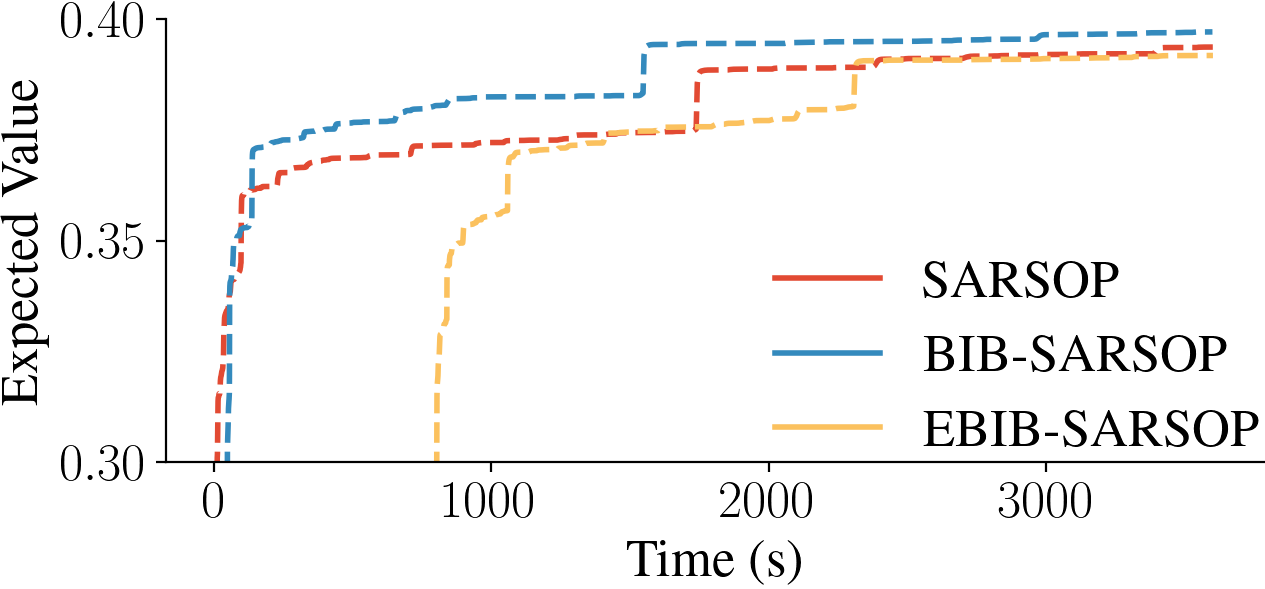

In [7]:
colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']
interesting = ["SparseHallway2"]


ts, ubs, lbs, solvernames, envname = get_data_plot("SparseHallway2")

for (i,label) in enumerate(solvernames):
    plt.plot(ts[i][1:],ubs[i][1:], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i][1:],lbs[i][1:], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Expected Value")

plt.ylim(0.3, 0.4)
# plt.xlim(0,1000)
plt.legend()
plt.show()

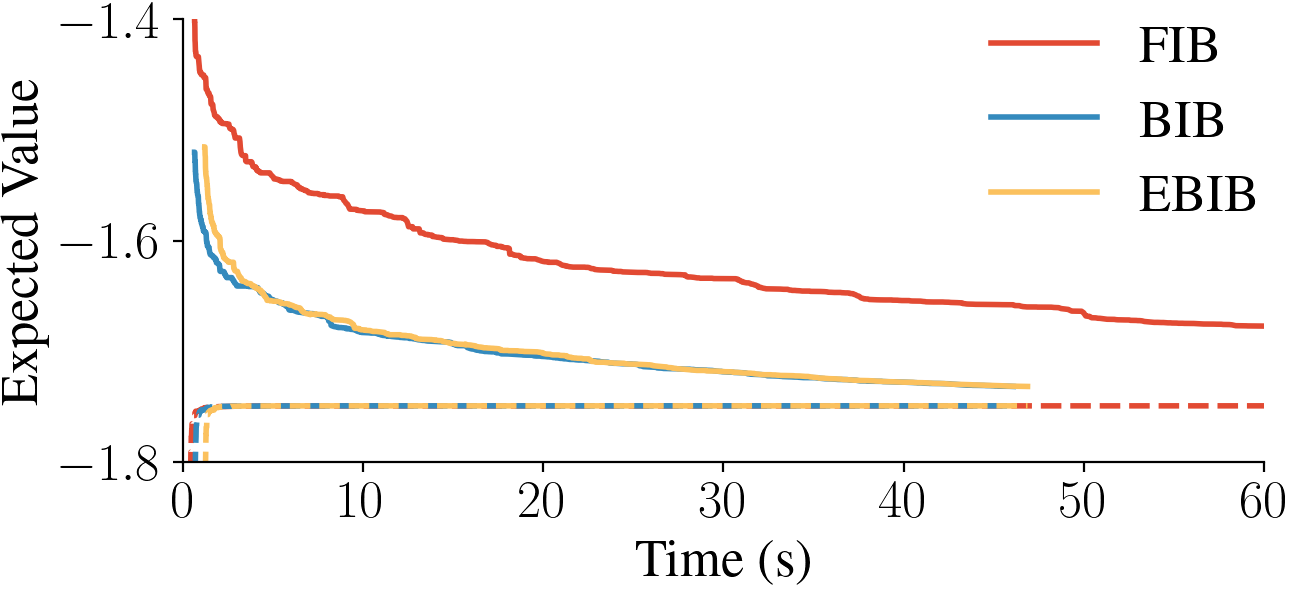

In [8]:
colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']
filename = "Data/Figures/SarsopTest_K-out-of-N2.pdf"


ts, ubs, lbs, solvernames, envname = get_data_plot("K-out-of-N2")

for (i,label) in enumerate(solvernames):
    label = solver_to_heuristic[label]
    plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Expected Value")

plt.ylim(-1.8, -1.4)
plt.xlim(0,60)
plt.legend()
plt.savefig(filename, transparent=True)
plt.show()

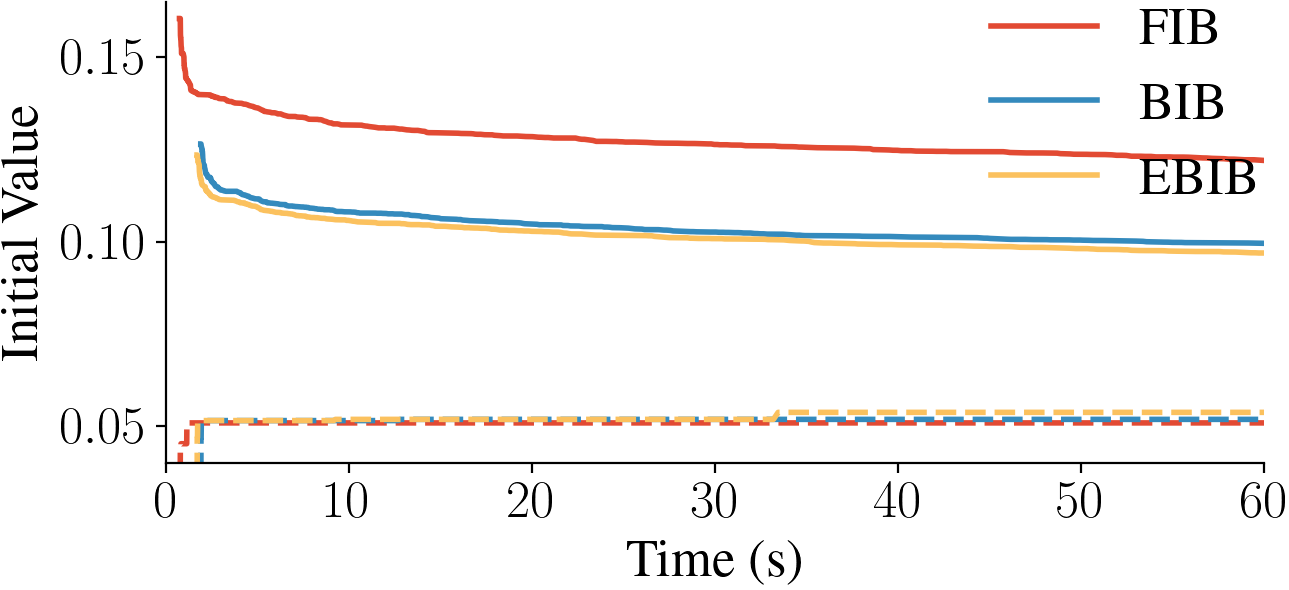

In [9]:
# K-out-of-N2

filename = "Data/Figures/SarsopTest_FrozenLake10.pdf"
ts, ubs, lbs, solvernames, envname = get_data_plot("FrozenLake10")

for (i,solver) in enumerate(solvernames):
    label = solver_to_heuristic[solver]
    # label = solver
    plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Initial Value")

plt.ylim(0.04, 0.165)
plt.xlim(0, 60)
plt.legend()
plt.savefig(filename, transparent=True)
plt.show()


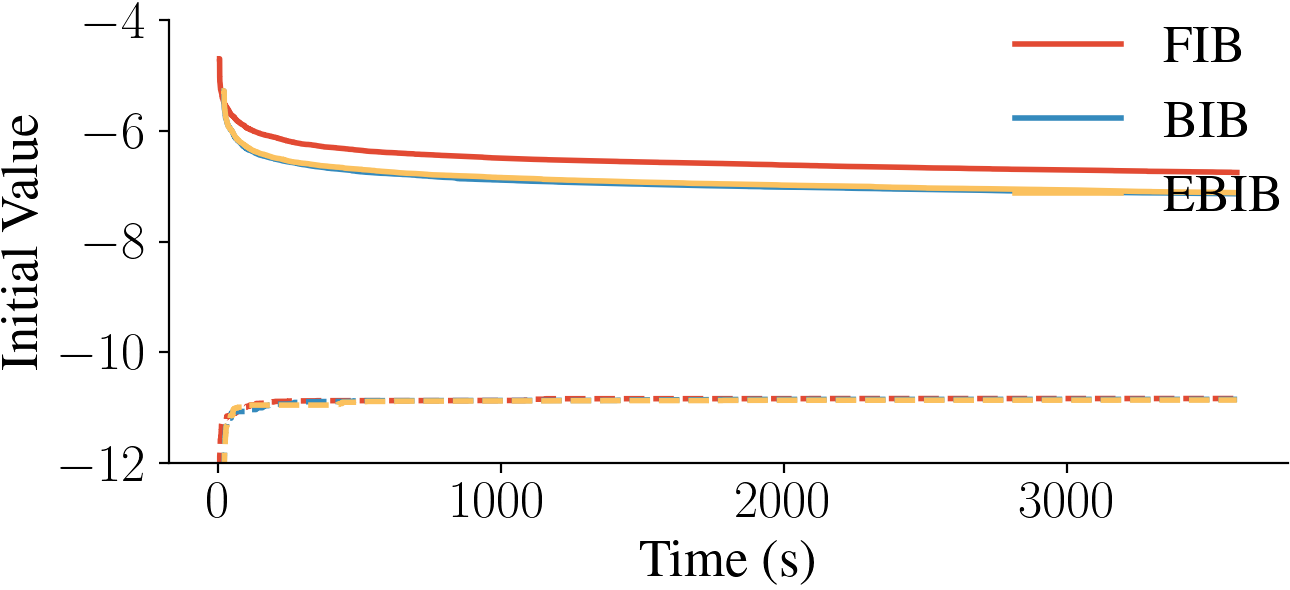

In [10]:
# K-out-of-N2

filename = "Data/Figures/SarsopTest_FrozenLake10.pdf"
ts, ubs, lbs, solvernames, envname = get_data_plot("Tag")

for (i,solver) in enumerate(solvernames):
    label = solver_to_heuristic[solver]
    # label = solver
    plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Initial Value")

plt.ylim(-12, -4)
# plt.xlim(0, 60)
plt.legend()
plt.savefig(filename, transparent=True)
plt.show()

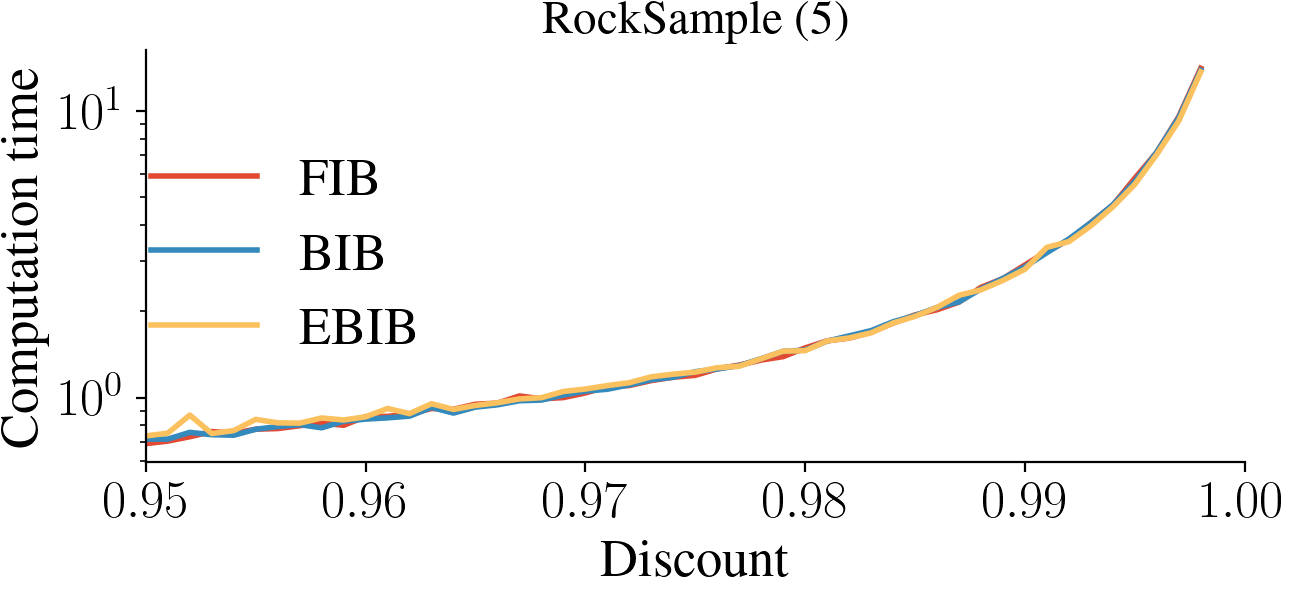

In [11]:
# FrozenLake5
filename = "Data/Figures/DiscountTest_RockSample5.pdf"
discounts = np.arange(0.95, 0.998, 0.001)
times, init_times, snames = get_data_discounts("RockSample5", discounts)

solvernames = ["FIB", "BIB", "EBIB"]

# plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts,times[i], label=solver, color=colours[i], linestyle="-")

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
# to_index = labels.index("TO")
# handles.append(handles.pop(to_index))
# labels.append(labels.pop(to_index))

plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time")

plt.xlim(0.95, 1)
plt.legend(handles, labels, loc='center left')
plt.title("RockSample (5)")
plt.savefig(filename, transparent=True)
plt.show()

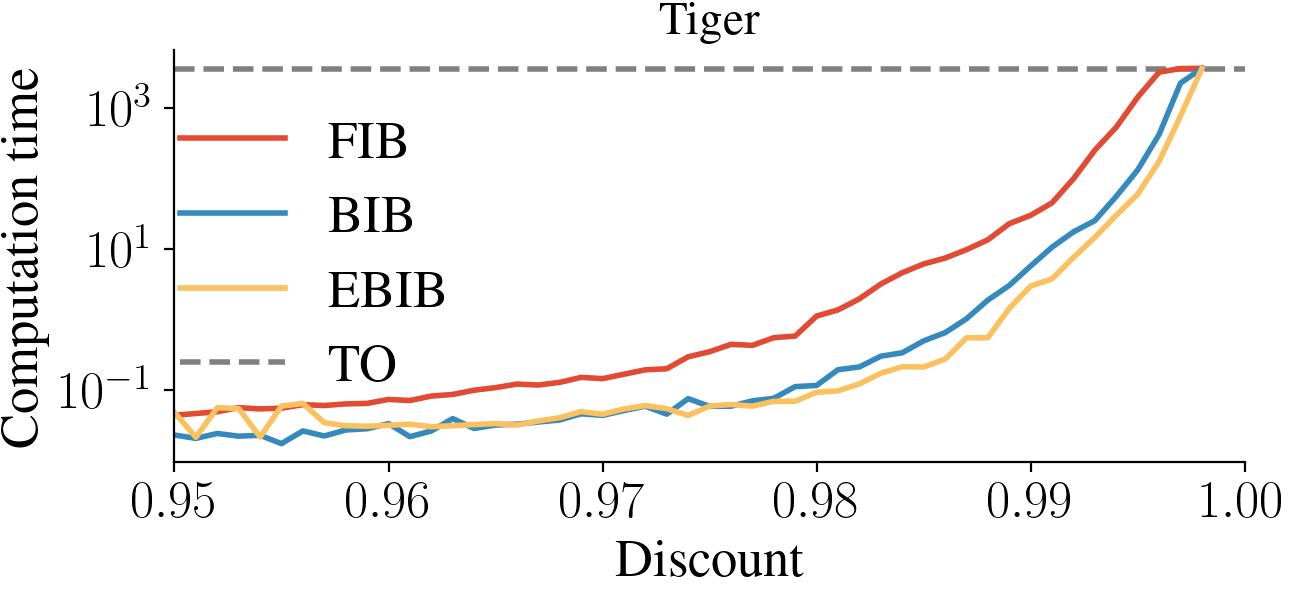

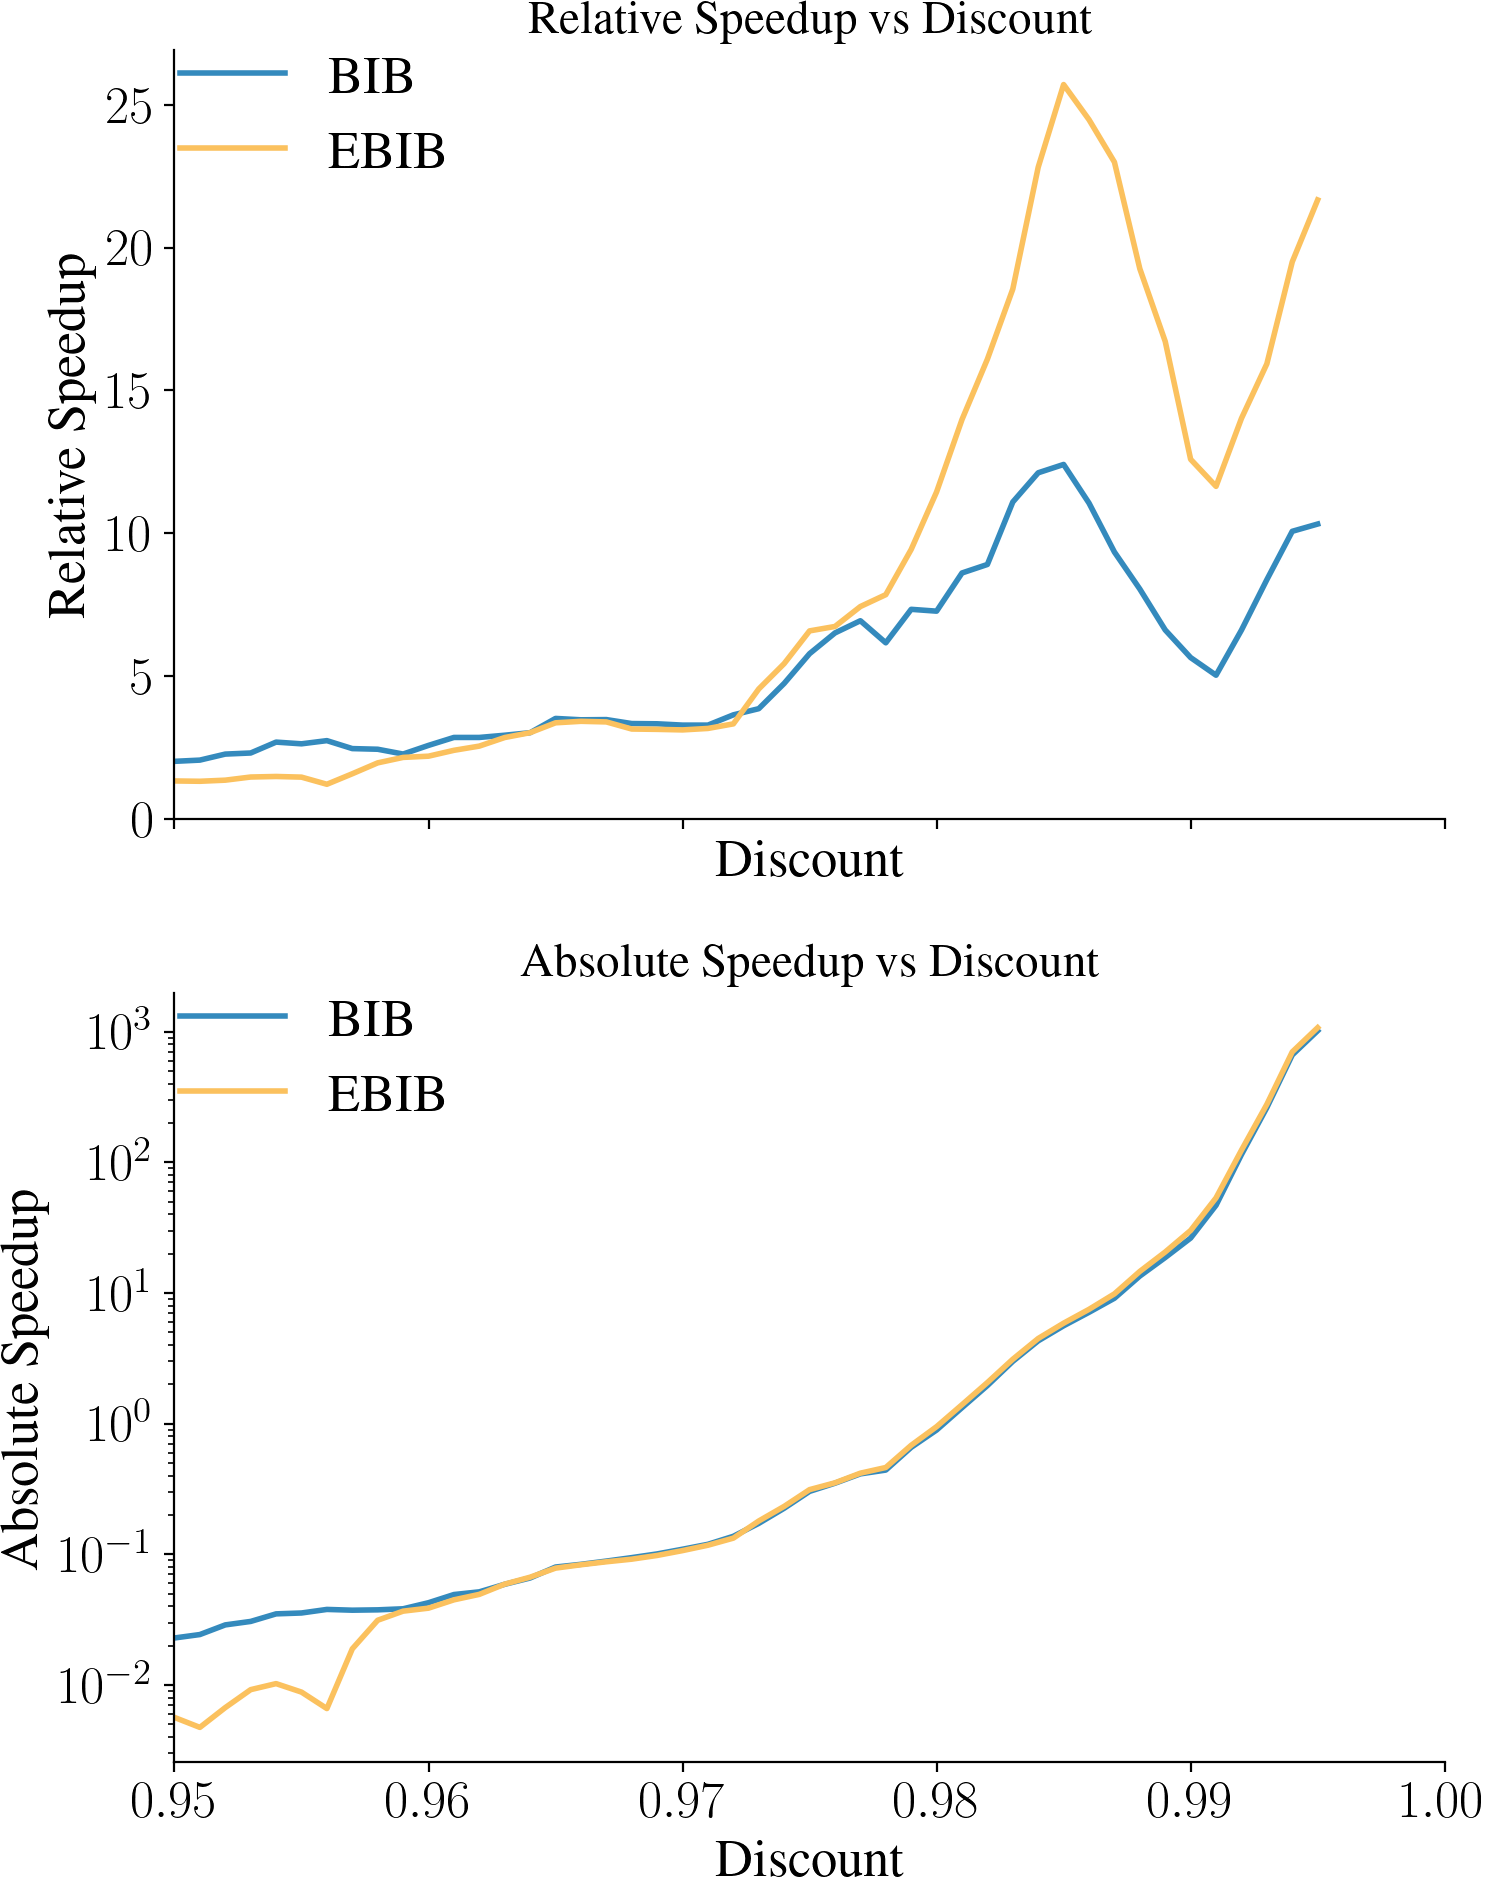

In [16]:
# Tiger
filename = "Data/Figures/DiscountTest_Tiger.pdf"
discounts = np.arange(0.95, 0.998, 0.001)
times, init_times, snames = get_data_discounts("Tiger", discounts)

solvernames = ["FIB", "BIB", "EBIB"]

plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts,times[i], label=solver, color=colours[i], linestyle="-")

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
to_index = labels.index("TO")
handles.append(handles.pop(to_index))
labels.append(labels.pop(to_index))

plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time")

plt.xlim(0.95, 1)
plt.legend(handles, labels, loc='center left')
plt.title("Tiger")
plt.savefig(filename, transparent=True)
plt.show()

# cut out part where FIB times out:
for i in range(len(times)):
    times[i] = times[i][:-3]

discounts = discounts[:-3]


speedup_rel_BIB = savgol_filter(np.divide(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_rel_EBIB = savgol_filter(np.divide(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_BIB = savgol_filter(np.subtract(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_EBIB = savgol_filter(np.subtract(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
# plt.xlim(0.95, 1)
# # plt.ylim(0,25)
# plt.plot(discounts,speedup_rel_BIB, color=colours[1], linestyle="-", label="BIB")
# plt.plot(discounts,speedup_rel_EBIB, color=colours[2], linestyle="-", label="EBIB")
# plt.legend(loc="upper left")
# plt.xlabel("Discount")
# plt.ylabel("Relative Speedup")
# plt.savefig("Data/Figures/DiscountTest_Tiger_relspeedup.pdf")
# plt.show()
# plt.xlim(0.95, 1)
# # plt.ylim(0,1000)
# plt.plot(discounts,speedup_abs_BIB, color=colours[1], linestyle="-", label="BIB")
# plt.plot(discounts,speedup_abs_EBIB, color=colours[2], linestyle="-", label="EBIB")
# plt.legend(loc="upper left")
# plt.xlabel("Discount")
# plt.ylabel("Absolute Speedup")
# plt.yscale("log")
# plt.savefig("Data/Figures/DiscountTest_Tiger_absspeedup.pdf")
# plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# First subplot: Relative Speedup
ax1.set_xlim(0.95, 1)
ax1.plot(discounts, speedup_rel_BIB, color=colours[1], linestyle="-", label="BIB")
ax1.plot(discounts, speedup_rel_EBIB, color=colours[2], linestyle="-", label="EBIB")
ax1.legend(loc="upper left")
ax1.set_xlabel("Discount")
ax1.set_ylabel("Relative Speedup")
# ax1.set_title("Relative Speedup vs Discount")  # Optional title for clarity

# Second subplot: Absolute Speedup
ax2.set_xlim(0.95, 1)
ax2.plot(discounts, speedup_abs_BIB, color=colours[1], linestyle="-", label="BIB")
ax2.plot(discounts, speedup_abs_EBIB, color=colours[2], linestyle="-", label="EBIB")
ax2.legend(loc="upper left")
ax2.set_xlabel("Discount")
ax2.set_ylabel("Absolute Speedup")
ax2.set_yscale("log")
# ax2.set_title("Absolute Speedup vs Discount")  # Optional title for clarity

# Adjust the layout so the plots don't overlap
plt.tight_layout()

# Save the figure if needed
plt.savefig("Data/Figures/DiscountTest_Tiger_speedup_subplots.pdf")

# Display the plots
plt.show()



0.974
3508.9622650146484
404.3441159725189
474.68137407302856
0.97
1271.5575048923492
250.47479605674744
258.72852993011475
0.95
159.3457260131836
45.559507846832275
47.029032945632935


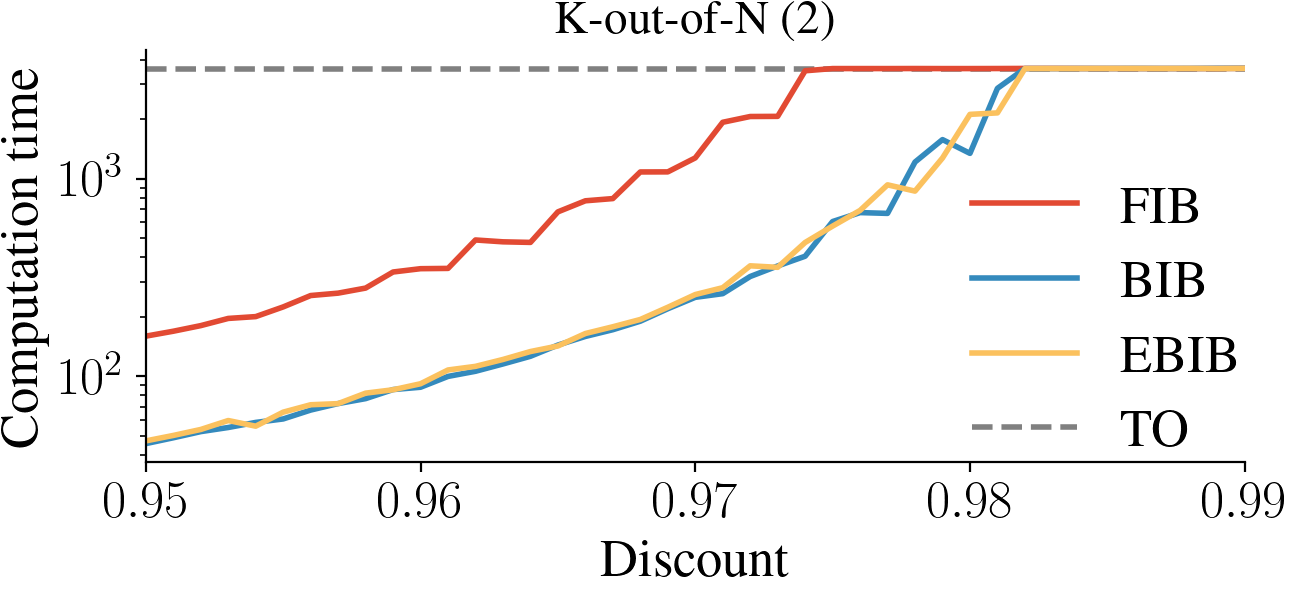

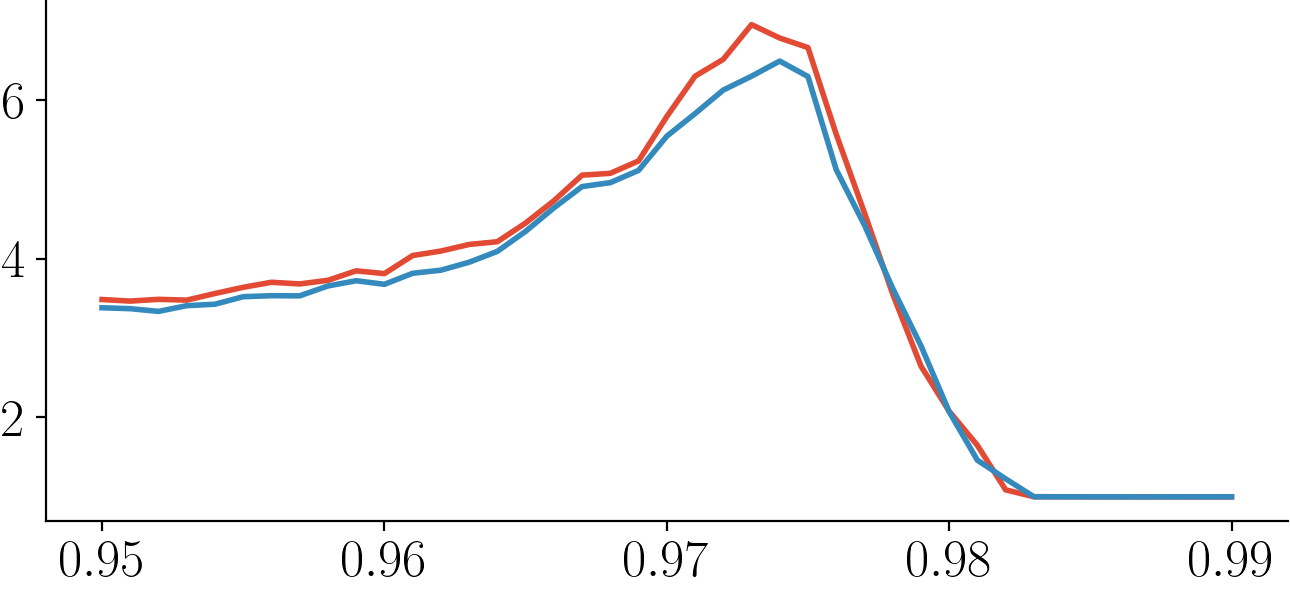

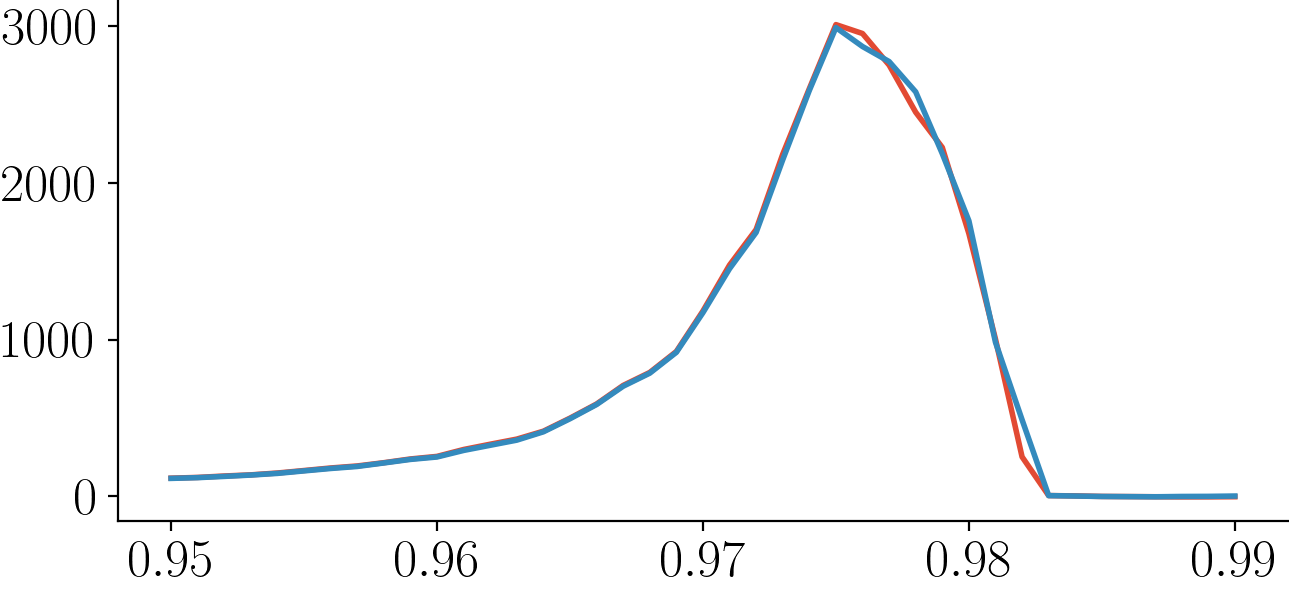

In [13]:
# K-out-of-N2
filename = "Data/Figures/DiscountTest_K-out-of-N2.pdf"
discounts = np.arange(0.95, 0.990, 0.001)
times, init_times, snames = get_data_discounts("K-out-of-N2", discounts)

solvernames = ["FIB", "BIB", "EBIB"]

plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts,times[i], label=solver, color=colours[i], linestyle="-")

print(discounts[24])
print(times[0][24])
print(times[1][24])
print(times[2][24])

print(discounts[20])
print(times[0][20])
print(times[1][20])
print(times[2][20])

print(discounts[0])
print(times[0][0])
print(times[1][0])
print(times[2][0])

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
to_index = labels.index("TO")
handles.append(handles.pop(to_index))
labels.append(labels.pop(to_index))

plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time")

plt.xlim(0.95, 0.99)
plt.legend(handles, labels, loc='best')
plt.title("K-out-of-N (2)")
plt.savefig(filename, transparent=True)
plt.show()


speedup_rel_BIB = savgol_filter(np.divide(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_rel_EBIB = savgol_filter(np.divide(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_BIB = savgol_filter(np.subtract(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_EBIB = savgol_filter(np.subtract(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
# speedup_rel_BIB = np.divide(times[0], times[1])
# speedup_rel_EBIB = np.divide(times[0], times[2])
# speedup_abs_BIB = np.subtract(times[0],times[1])
# speedup_abs_EBIB = np.subtract(times[0],times[2])
# plt.xlim(0.95, 0.974)
# plt.ylim(0,25)
plt.plot(discounts,speedup_rel_BIB)#, color=colours[i], linestyle="-")
plt.plot(discounts,speedup_rel_EBIB)#, color=colours[i], linestyle="-")
plt.show()
# plt.xlim(0.95, 0.974)
# plt.ylim(0,1000)
plt.plot(discounts,speedup_abs_BIB)#, color=colours[i], linestyle="-")
plt.plot(discounts,speedup_abs_EBIB)#, color=colours[i], linestyle="-")
# plt.yscale("log")
plt.show()






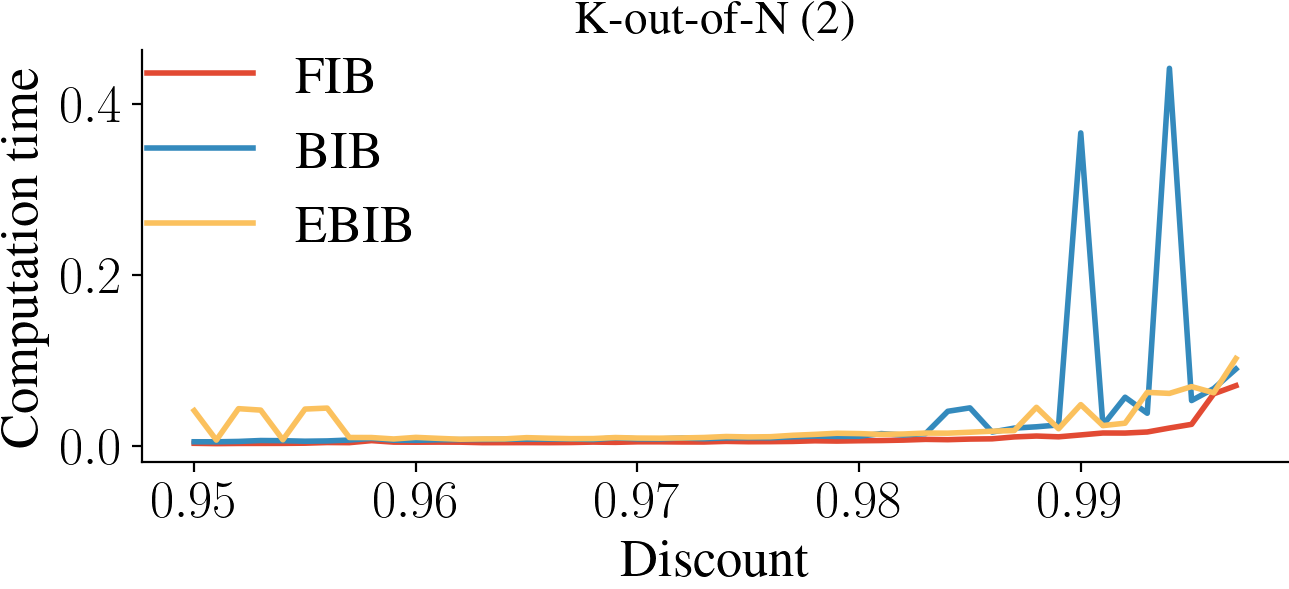

In [14]:
# K-out-of-N2
filename = "Data/Figures/DiscountTest_K-out-of-N2_heuristic.pdf"
discounts = np.arange(0.95, 0.998, 0.001)
times, init_times, snames = get_data_discounts("Tiger", discounts)

solvernames = ["FIB", "BIB", "EBIB"]

# plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts[:-1],init_times[i][:-1], label=solver, color=colours[i], linestyle="-")

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
# to_index = labels.index("TO")
# handles.append(handles.pop(to_index))
# labels.append(labels.pop(to_index))

# plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time")

# plt.xlim(0.95, 0.99)
plt.legend(handles, labels, loc='best')
plt.title("K-out-of-N (2)")
plt.savefig(filename, transparent=True)
plt.show()